In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [4]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [5]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves, get_feature_names
from kndetect.training import append_y_true_col
from kndetect.predict import filter_no_coeff_events
from kndetect.activelr import run_AL_loops

In [6]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [7]:
use_already_trained_features = True
use_already_trained_models = False
mimic_alerts = False
save_data = True
save_results_plots = True
sub_directory=None

use_AL = True
use_already_trained_AL_features = False

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"
    
plot_path_prefix=None
if save_results_plots:
    plot_path_prefix = sub_directory

In [8]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"),index_col=0)

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [9]:
train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,type,type_names,y_true,y_pred,y_score
0,0.290510,0.095632,0.074392,1.104283,230.670456,0.275086,0.113414,0.075967,1.964267,373.748047,1757,150,150: KN GW170817,True,True,0.948956
1,0.514803,0.116128,-0.073609,1.146572,427.853790,1.017285,-0.065936,-0.210053,1.474833,788.683228,6415,141,141: 91BG,False,False,0.000000
2,1.067839,-0.114932,0.315341,0.990398,270.629425,1.096944,-0.036559,0.173198,0.974568,518.246521,7707,103,103: Core collapse Type Ibc,False,False,0.000000
4,0.785228,0.026194,-0.227322,1.078376,263.286224,0.493918,-0.199459,-0.287732,0.937045,291.099426,12578,102,102: MOSFIT-Ibc,False,False,0.000000
5,0.516106,0.123479,-0.052812,2.191080,636.599168,0.748878,0.128943,-0.032813,0.905214,383.834531,15888,149,149: KN GRANDMA,True,True,0.837588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,1.088962,-0.014523,0.106654,1.693484,888.318420,1.205512,-0.059662,0.725981,1.578576,666.974243,137062467,112,112: Core collapse Type II,False,False,0.000000
22276,0.978098,-0.118905,-0.022548,1.571079,1141.677979,1.038589,-0.084343,0.017370,1.344228,1213.934937,137071784,170,170: AGN,False,False,0.000000
22277,0.934356,-0.129008,-0.007231,1.264973,295.870941,0.944728,-0.036172,-0.020847,0.761197,408.148193,137071978,143,143: Iax,False,False,0.000000
22278,0.206614,0.121759,0.131741,2.082643,525.301697,0.306185,0.283979,-0.027413,1.448031,445.314880,137079473,151,151: KN Karsen 2017,True,True,0.944313


In [10]:
filter_indices = filter_no_coeff_events(train_features_df)
filtered_train_features_df = train_features_df[filter_indices]

In [11]:
if use_AL:
    if use_already_trained_AL_features:
        data_path=os.path.join(data_dir, sub_directory, "AL", "train.csv")
        filtered_train_features_df = pd.read_csv(data_path)
    else:
        data_base_path=os.path.join(data_dir, sub_directory)
        feature_names = get_feature_names()
        filtered_train_features_df = filtered_train_features_df[['key', 'y_true'] + feature_names]
        filtered_train_features_df.reset_index(inplace=True, drop=True)

        filtered_train_features_df = run_AL_loops(features_df=filtered_train_features_df, save_data=save_data, nloops=1490, data_base_path=data_base_path)


 temp_labels =  8854      True
13882     True
11572     True
260       True
12826     True
10513    False
19389    False
12443    False
3472     False
12957    False
Name: type, dtype: bool 

Training set size:  10
Test set size:  19496
  from which queryable:  19496
Processing...  0

 Metrics:  [0.8052421009437833, 0.9508784510577268, 0.42015209125475284, 0.1849860366934486]

 Inside make_query: 
       ... classprob:  19496
       ... queryable_ids:  19496
       ... test_ids:  19496

 Inside UncSampling: 
       query_ids:  [59259445] 

   number of test_ids:  19496
   number of queryable_ids:  19496 

   *** Displacement caused by constraints on query****
   0 ->  0
    [0.5 0.5] -- >  [0.5 0.5] 

indx:  [9493]
Processing...  1

 Metrics:  [0.8169274172864837, 0.9569738257439943, 0.436253677672442, 0.1962325707522066]

 Inside make_query: 
       ... classprob:  19495
       ... queryable_ids:  19495
       ... test_ids:  19495

 Inside UncSampling: 
       query_ids:  [31774778] 

In [12]:
filtered_train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,y_true
0,0.599443,0.181942,-0.077817,1.698075,455.282919,0.616026,0.308516,-0.052482,2.896297,2386.32118,1177543,True
1,1.045788,-0.100424,-0.033571,4.447806,2511.173096,1.253448,-0.137629,0.077481,2.284842,3576.018066,15997766,False
2,0.369584,0.09373,0.055032,1.749274,412.471558,0.452297,0.245538,-0.127057,1.790894,507.966858,54190180,True
3,1.069314,0.059075,0.112087,1.245963,735.217468,1.260573,-0.054118,0.17097,1.703808,687.767334,67154802,False
4,0.355371,0.084824,0.03962,2.402329,585.255127,0.404777,0.203,-0.119711,2.435782,729.357483,75368242,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.130851,0.012803,0.03134,17.351467,7306.038574,0.046621,0.01606,0.013478,30.899091,18861.833984,120943559,True
1496,0.25769,0.170554,0.079185,2.052613,525.195068,0.286014,0.188239,0.187956,1.196409,309.787323,29861244,True
1497,-0.007174,0.579568,-0.261612,4.303175,754.298157,0.764392,0.234515,0.022207,1.614738,1121.322144,68948248,False
1498,0.375485,0.141767,0.238144,4.654506,1381.802734,0.529907,0.075582,0.234737,4.101872,1307.532227,31757353,True


# Now Train the classifier

In [13]:
from kndetect.training import train_classifier

In [14]:
if not use_already_trained_models:
    clf, filtered_train_features_df = train_classifier(filtered_train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    data_base_path=os.path.join(data_dir, sub_directory)
    feature_names = get_feature_names()
    filtered_train_features_df = filtered_train_features_df[['key', 'y_true'] + feature_names]
    filtered_train_features_df.reset_index(inplace=True, drop=True)

    filtered_train_features_df = run_AL_loops(features_df=filtered_train_features_df, save_data=save_data, nloops=1490, data_base_path=data_base_path)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


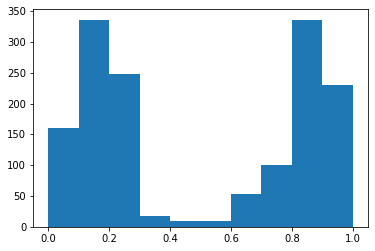

In [15]:
fig = plt.figure()
plt.hist(filtered_train_features_df['y_score']);
plt.savefig("score_distrib")

In [16]:
# Generate Test features and Predict probabilities

In [17]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [18]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [19]:
from kndetect.predict import load_classifier, predict_kn_score

In [20]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)

In [21]:
test_features_df['y_score'] = probabilities.T[1]

In [22]:
filtered=test_features_df[filtered_indices]

In [23]:
filtered_train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,y_true,y_pred,y_score
0,0.599443,0.181942,-0.077817,1.698075,455.282919,0.616026,0.308516,-0.052482,2.896297,2386.32118,1177543,True,True,0.900000
1,1.045788,-0.100424,-0.033571,4.447806,2511.173096,1.253448,-0.137629,0.077481,2.284842,3576.018066,15997766,False,False,0.000000
2,0.369584,0.09373,0.055032,1.749274,412.471558,0.452297,0.245538,-0.127057,1.790894,507.966858,54190180,True,True,0.866667
3,1.069314,0.059075,0.112087,1.245963,735.217468,1.260573,-0.054118,0.17097,1.703808,687.767334,67154802,False,False,0.000000
4,0.355371,0.084824,0.03962,2.402329,585.255127,0.404777,0.203,-0.119711,2.435782,729.357483,75368242,True,True,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.130851,0.012803,0.03134,17.351467,7306.038574,0.046621,0.01606,0.013478,30.899091,18861.833984,120943559,True,True,0.800000
1496,0.25769,0.170554,0.079185,2.052613,525.195068,0.286014,0.188239,0.187956,1.196409,309.787323,29861244,True,True,1.000000
1497,-0.007174,0.579568,-0.261612,4.303175,754.298157,0.764392,0.234515,0.022207,1.614738,1121.322144,68948248,False,False,0.066667
1498,0.375485,0.141767,0.238144,4.654506,1381.802734,0.529907,0.075582,0.234737,4.101872,1307.532227,31757353,True,True,0.833333


In [24]:
y_true_train = filtered_train_features_df["y_true"]
y_pred_train = filtered_train_features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))

train statistics:

total number of events: 1500
total number of KN: 728
total number of non KN: 772

True Positive : 727
False Positive : 1
True negative : 771
False negative : 1


In [25]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_pred_score"]>0.5

In [26]:
tp = np.sum(y_true&y_pred)
fp = np.sum(~y_true&y_pred)
tn = np.sum(~y_true&~y_pred)
fn = np.sum(y_true&~y_pred)

In [27]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {}".format(tp))
print("False Positive : {}".format(fp))
print("True negative : {}".format(tn))
print("False negative : {}".format(fn))

test statistics:

total number of events: 18715
total number of KN: 1892
total number of non KN: 16823

True Positive : 1766
False Positive : 1149
True negative : 15674
False negative : 126


In [28]:
precision = tp * 100 / (tp+fp)
recall = tp*100 / (tp+fn)

print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))

Precision: 60.58%
Recall: 93.34%


In [29]:
from kndetect.plot_lightcurve import plot_confusion_matrix

[[0.83751002 0.0613946 ]
 [0.00673257 0.09436281]]


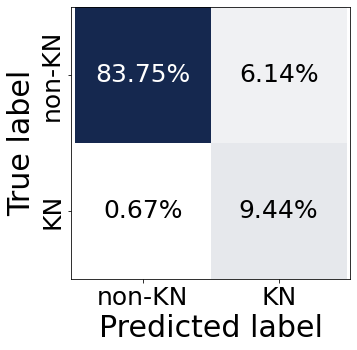

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred, save_fig_prefix=plot_path_prefix)

In [31]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

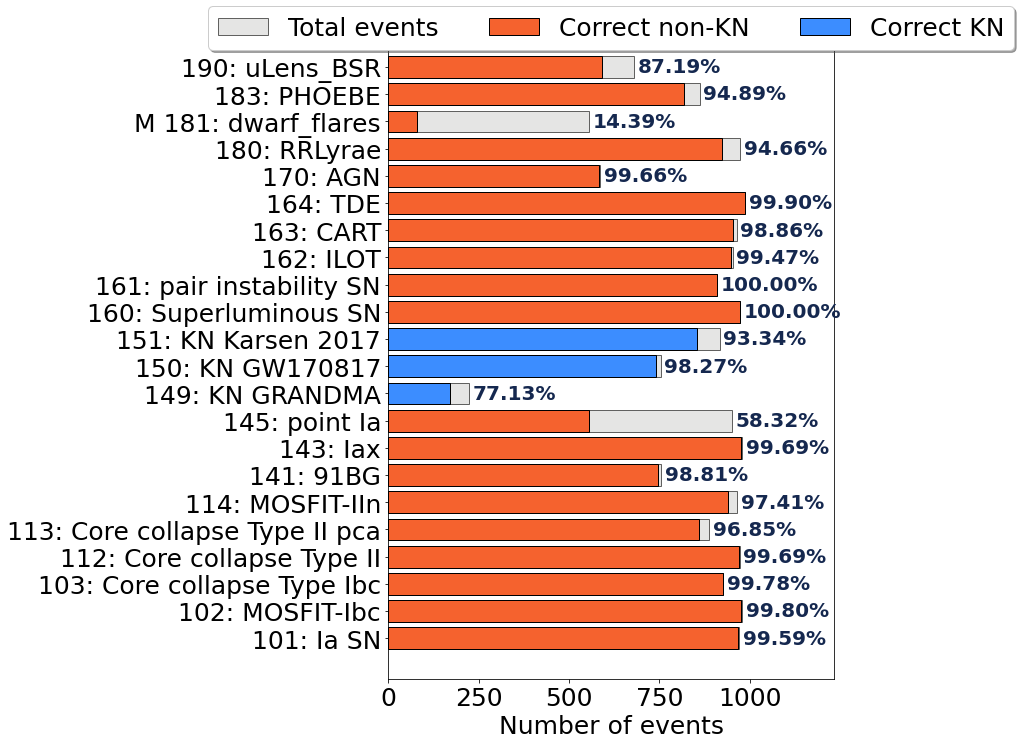

In [32]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,12))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151], save_fig_prefix=plot_path_prefix)
#plt.show()

In [33]:
from kndetect.plot_lightcurve import plot_features_correlation
from kndetect.plot_lightcurve import plot_band_correlation
import seaborn as sns

Using matplotlib backend: <object object at 0x7fb2ba5d9ae0>


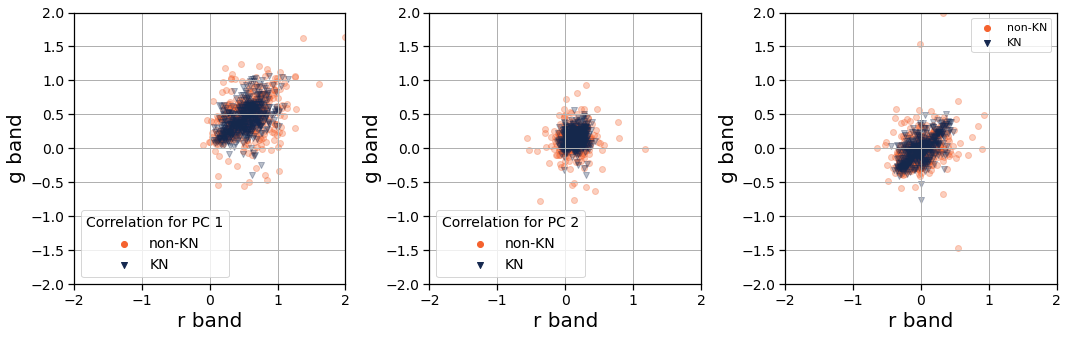

In [34]:
%matplotlib
plot_band_correlation(filtered_train_features_df, bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=500, num_non_kn_points=500, save_fig_prefix=plot_path_prefix)

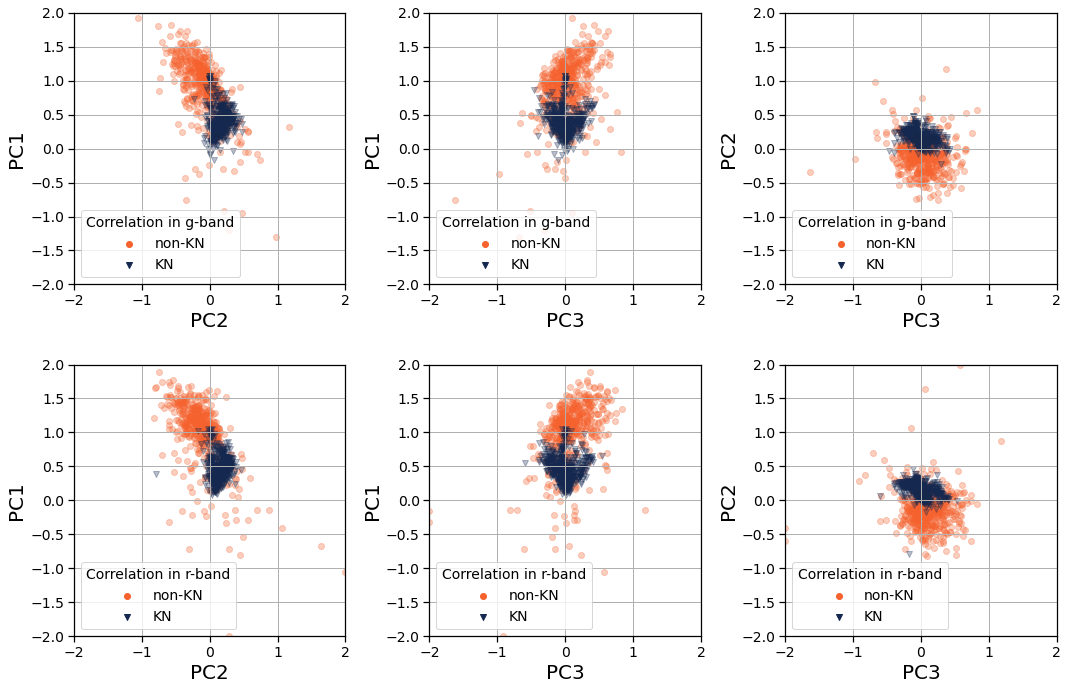

In [35]:
plot_features_correlation(filtered, color_dict = {'non_kn':'#F5622E', 'kn': '#15284F'},bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=500, num_non_kn_points=500, save_fig_prefix=plot_path_prefix)